# Running Pace Analysis Models

## Initial Code

Imports

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time 
from datetime import datetime
import warnings

plt.style.use('ggplot')
warnings.filterwarnings('ignore')

int_start = time.perf_counter()

In [113]:
df = pd.read_csv('HeartWatch-Workouts-20230717-to-20230829.csv')

Select Running activities and drop irrelevant columns

In [114]:
df = df[df['Type'] == 'Running'].reset_index(drop=True)
df = df.drop(['Type', 'rpe', 'ISO', 'Date', 'to','90%+-mins', '80-90%-mins',
             '70-80%-mins', '60-70%-mins', '50-60%-mins', 'Load', 'Cals', 'Cals/h',
             '/km', 'km/h', 'bpm-%'],axis=1)

Convert Duration into total seconds   
Convert Activity start time to hour decimal in 24hr time    
Calculate Pace

In [115]:
df['Duration'] = pd.to_timedelta(df['Duration'])
df['Duration'] = df['Duration'].dt.total_seconds()

# Convert the 'from' column to datetime format
df['from'] = pd.to_datetime(df['from'], format='%I:%M %p')

# Extract hour and minute information
df['hour'] = df['from'].dt.hour
df['minute'] = df['from'].dt.minute

df['hour'] = round(df['hour'] + (df['minute']/60),3)

df = df.drop(['from', 'minute'], axis=1)

df['Pace'] = (df['Duration'] / 60) / df['km']

In [116]:
df.head()

,Duration,bpm-Avg.,bpm-lo,bpm-hi,bpm-90%+-%,bpm-80-90%-%,bpm-70-80%-%,bpm-60-70%-%,bpm-50-60%-%,km,hour,Pace
0,1804.0,155.9,110.0,164.0,NaN,79.5,19.6,0.7,0.2,3.81,11.883,7.891514
1,2216.0,157.3,88.0,170.0,NaN,80.3,13.1,4.9,0.5,5.06,8.750,7.299078
2,1891.0,152.8,102.0,181.0,2.7,50.5,43.5,2.9,0.5,4.08,8.833,7.724673
3,2244.0,157.0,94.0,168.0,NaN,85.1,12.3,1.3,1.1,5.38,9.117,6.951673
4,3631.0,145.9,104.0,155.0,NaN,0.6,93.6,5.3,0.5,7.49,8.733,8.079662


### Correlation Matrix

Pace            1.000000
bpm-Avg.        0.622623
bpm-50-60%-%    0.605836
km              0.524776
bpm-90%+-%      0.509929
bpm-60-70%-%    0.370533
bpm-80-90%-%    0.346551
Duration        0.331300
bpm-hi          0.299981
bpm-lo          0.245598
hour            0.203075
bpm-70-80%-%    0.104398
Name: Pace, dtype: float64


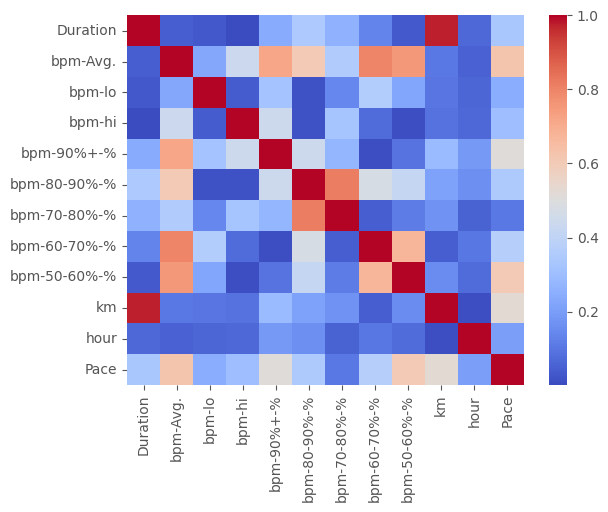

In [117]:
corr_mtrx = df.corr().abs()
sns.heatmap(corr_mtrx, cmap='coolwarm')
print(corr_mtrx['Pace'].sort_values(ascending=False))

### Summary Statistics

In [118]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Duration,24.0,2916.083333,902.199579,1788.000000,2267.250000,2788.000000,3428.000000,4886.000000
bpm-Avg.,24.0,149.108333,8.700171,118.400000,146.775000,150.900000,154.050000,160.200000
bpm-lo,24.0,94.916667,10.619574,72.000000,87.250000,94.000000,102.500000,117.000000
bpm-hi,24.0,170.250000,15.220838,150.000000,160.750000,167.000000,177.000000,218.000000
bpm-90%+-%,8.0,11.212500,11.965120,0.800000,2.500000,6.000000,17.225000,30.000000
bpm-80-90%-%,22.0,35.504545,27.912235,0.600000,10.100000,34.550000,54.200000,85.100000
bpm-70-80%-%,24.0,53.658333,26.409055,12.300000,29.650000,52.350000,73.275000,96.500000
bpm-60-70%-%,24.0,7.025000,7.581055,0.700000,2.525000,4.750000,6.525000,28.800000
bpm-50-60%-%,23.0,1.782609,3.082893,0.200000,0.400000,0.800000,1.700000,15.100000
km,24.0,6.730417,2.427832,3.810000,5.135000,6.365000,7.620000,12.610000


#### Histograms

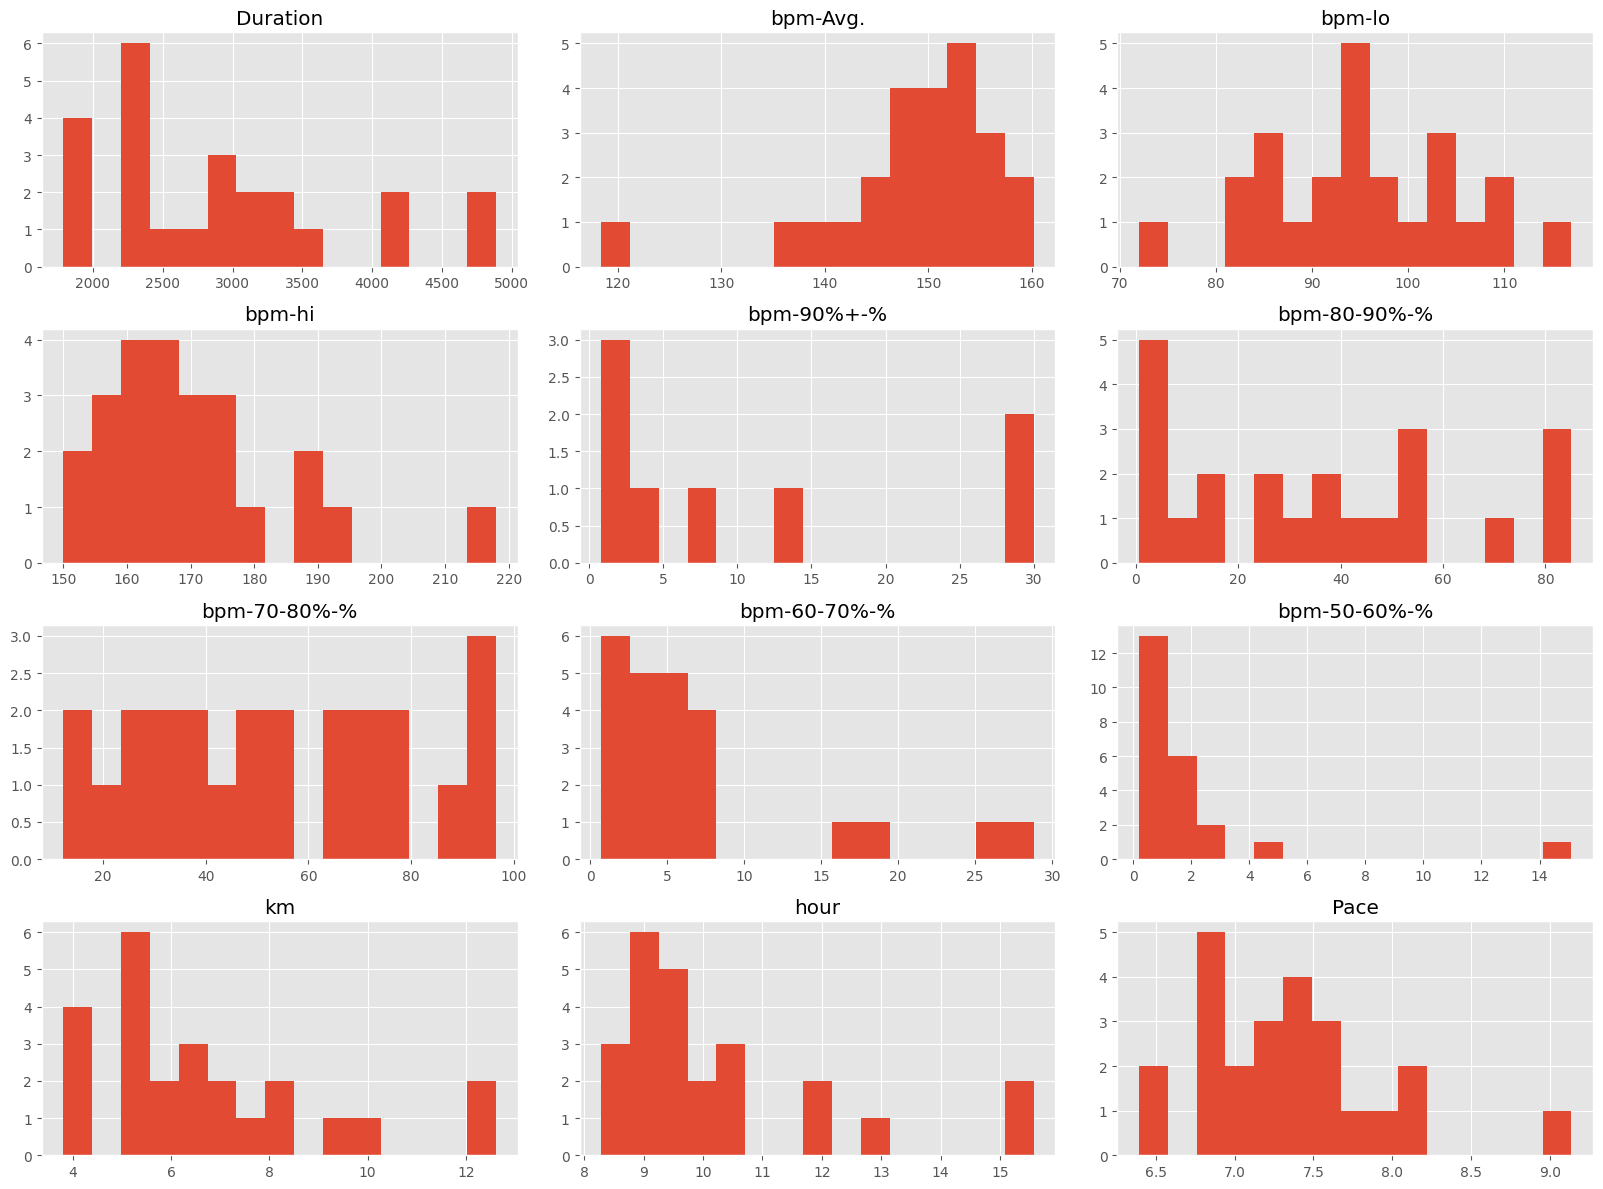

In [119]:
df.hist(bins=15, figsize=(16, 12))
plt.tight_layout()
plt.show()

### Train/Test Split and Scaling

In [120]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [121]:
# Define features (X) and target variable (y)
X = df.drop('Pace', axis=1) 
y = df['Pace'] 

print(f'X Shape: {X.shape}')
print(f'Y Shape: {y.shape}')

X Shape: (24, 11)
Y Shape: (24,)


In [122]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=1#121)
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Shape: {X_test.shape}')

X Train Shape: (19, 11)
X Test Shape: (5, 11)


In [123]:
pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value=0), StandardScaler())

X_train_processed = pipe.fit_transform(X_train)
X_test_processed = pipe.transform(X_test)

print(f'X_train_prcsd shape: {X_train_processed.shape}')
print(f'X_test_prcsd shape: {X_test_processed.shape}')

X_train_prcsd shape: (19, 11)
X_test_prcsd shape: (5, 11)


### Results Functions

In [124]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

MSE_Histmean = mean_squared_error(y_test,np.full(y_test.shape,np.mean(y_train)))

def ResultsOut(model):
  y_pred = model.predict(X_test_processed)
  # Calculate regression metrics
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred, squared=False)
  r2 = r2_score(y_test, y_pred)
  oosr2 = 1-mean_squared_error(y_test,y_pred)/MSE_Histmean
  # Print the metrics with newline characters
  print("MAE: {:.2f}".format(mae))
  print("MSE: {:.2f}".format(mse))
  print("RMSE: {:.2f}".format(rmse))
  print("R^2 Score: {:.2f}".format(r2))
  print("OOS R^2 Score: {:.2f}".format(oosr2))
  return ''

def paramResults(mod):
    results_df = pd.DataFrame({'param': mod.cv_results_["params"], 'Accuracy': mod.cv_results_["mean_test_score"]})

    # Splitting the 'param' column into separate columns
    params_df = pd.DataFrame(results_df['param'].to_list())
    params_df.columns = [f"{col}_param" for col in params_df.columns]

    # Concatenating the new columns with the 'Accuracy' column
    results_df = pd.concat([params_df, results_df['Accuracy']], axis=1)

    # Displaying the updated DataFrame
    print(results_df)
    return ''

def featImport(mod):
    feat_importances = pd.DataFrame(mod.best_estimator_.feature_importances_[:11], index=X_train.columns, columns=["Importance"])
    feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
    feat_importances.plot(kind='bar', figsize=(8,6))
    plt.show()

## Models

### Linear Regression

In [125]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train_processed,y_train)
linreg_preds = linreg.predict(X_test_processed)

print(ResultsOut(linreg))

MAE: 0.69
MSE: 0.68
RMSE: 0.82
R^2 Score: -6.21
OOS R^2 Score: -0.57



### Ridge

In [126]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

Alpha = [10**4,10**3,10**2,10**1,10**0,10**-1,10**-2,10**-3]

# Scoring in sklearn is done by choosing the largest value
param_grid_ridge={'alpha':Alpha}

ridge = GridSearchCV(Ridge(),param_grid=param_grid_ridge,cv=5,n_jobs=-1)

ridge.fit(X_train_processed,y_train)
ridge_preds = ridge.predict(X_test_processed)

print(ridge.best_estimator_)
print(paramResults(ridge))
print(ResultsOut(ridge))

Ridge(alpha=0.01)
   alpha_param  Accuracy
0    10000.000 -0.826456
1     1000.000 -0.820997
2      100.000 -0.762446
3       10.000 -0.409123
4        1.000 -0.209697
5        0.100  0.263777
6        0.010  0.723894
7        0.001  0.519077

MAE: 0.70
MSE: 0.71
RMSE: 0.84
R^2 Score: -6.47
OOS R^2 Score: -0.63



### Lasso

In [127]:
from sklearn.linear_model import Lasso

lasso = GridSearchCV(Lasso(max_iter=10000),param_grid=param_grid_ridge,cv=5,n_jobs=-1)

lasso.fit(X_train_processed,y_train)
lasso_preds = ridge.predict(X_test_processed)

print(lasso.best_estimator_)
print(paramResults(lasso))
print(ResultsOut(lasso))

Lasso(alpha=0.001, max_iter=10000)
   alpha_param  Accuracy
0    10000.000 -0.827055
1     1000.000 -0.827055
2      100.000 -0.827055
3       10.000 -0.827055
4        1.000 -0.827055
5        0.100 -0.572454
6        0.010  0.292130
7        0.001  0.682366

MAE: 0.63
MSE: 0.55
RMSE: 0.74
R^2 Score: -4.79
OOS R^2 Score: -0.26



### Elastic Net

In [128]:
from sklearn.linear_model import ElasticNet

param_grid_elastic = {'l1_ratio':[.25, .5, .75],'alpha':Alpha}

elasnet = GridSearchCV(ElasticNet(max_iter=10000),param_grid=param_grid_elastic,cv=5,n_jobs=-1)
elasnet.fit(X_train_processed,y_train)
elasnet.predict(X_test_processed)

print(elasnet.best_estimator_)
print(paramResults(elasnet))
print(ResultsOut(elasnet))

ElasticNet(alpha=0.001, l1_ratio=0.25, max_iter=10000)
    alpha_param  l1_ratio_param  Accuracy
0     10000.000            0.25 -0.827055
1     10000.000            0.50 -0.827055
2     10000.000            0.75 -0.827055
3      1000.000            0.25 -0.827055
4      1000.000            0.50 -0.827055
5      1000.000            0.75 -0.827055
6       100.000            0.25 -0.827055
7       100.000            0.50 -0.827055
8       100.000            0.75 -0.827055
9        10.000            0.25 -0.827055
10       10.000            0.50 -0.827055
11       10.000            0.75 -0.827055
12        1.000            0.25 -0.839465
13        1.000            0.50 -0.829495
14        1.000            0.75 -0.827055
15        0.100            0.25 -0.077948
16        0.100            0.50 -0.260310
17        0.100            0.75 -0.427454
18        0.010            0.25  0.216912
19        0.010            0.50  0.327239
20        0.010            0.75  0.291155
21        0.001      

### PCA

In [129]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline

pipe = Pipeline([("pca", PCA()),
                 ("ols", LinearRegression())])

param_grid = [{"pca__n_components" : range(1,X_train_processed.shape[1],int(np.ceil(X_train_processed.shape[1]/10)))}]

pcr = GridSearchCV(pipe, param_grid=param_grid, cv=5)
pcr.fit(X_train_processed, y_train)
pcr_preds = pcr.predict(X_test_processed)

print(pcr.best_estimator_)
print(paramResults(pcr))
print(ResultsOut(pcr))

Pipeline(steps=[('pca', PCA(n_components=9)), ('ols', LinearRegression())])
   pca__n_components_param  Accuracy
0                        1 -1.434061
1                        3 -1.270109
2                        5 -0.474018
3                        7 -0.705325
4                        9 -0.352674

MAE: 1.08
MSE: 2.51
RMSE: 1.58
R^2 Score: -25.57
OOS R^2 Score: -4.79



### K-Nearest Neighbours

In [130]:
from sklearn.neighbors import KNeighborsRegressor

param_grid = {'n_neighbors': [1, 3, 5, 7, 9]} 
knn = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5)
knn.fit(X_train_processed, y_train)

knn_pred = best_knn_model.predict(X_test_processed)

print(knn.best_estimator_)
print(paramResults(knn))
print(ResultsOut(knn))

KNeighborsRegressor(n_neighbors=7)
   n_neighbors_param  Accuracy
0                  1 -1.273876
1                  3 -0.975886
2                  5 -0.842926
3                  7 -0.543730
4                  9 -0.620552

MAE: 0.43
MSE: 0.24
RMSE: 0.49
R^2 Score: -1.50
OOS R^2 Score: 0.46



### Random Forest

RandomForestRegressor(max_depth=3, max_features='sqrt', n_estimators=35,
                      random_state=42069)
    max_depth_param  n_estimators_param  Accuracy
0                 3                  25 -1.200223
1                 3                  35 -1.019515
2                 3                  45 -1.026246
3                 3                  55 -1.088445
4                 3                  65 -1.070883
5                 3                  75 -1.070950
6                 3                  85 -1.049704
7                 3                  95 -1.053271
8                 5                  25 -1.189858
9                 5                  35 -1.025114
10                5                  45 -1.071364
11                5                  55 -1.103769
12                5                  65 -1.087781
13                5                  75 -1.108113
14                5                  85 -1.078286
15                5                  95 -1.069202
16                7                

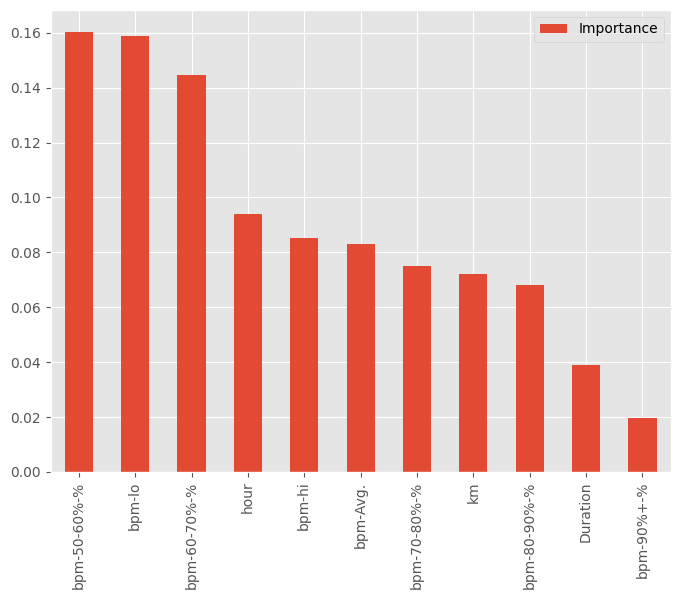

In [131]:
from sklearn.ensemble import RandomForestRegressor

param_grid_rf = {'n_estimators': range(25,100,10),'max_depth': range(3,9,2)}

rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42069,max_features='sqrt'), cv=5, param_grid=param_grid_rf,n_jobs=-1)
# rf = RandomForestRegressor(random_state=42069,max_features='sqrt', n_estimators=35, max_depth=5)
rf.fit(X_train_processed, y_train)

print(rf.best_estimator_)
print(paramResults(rf))
print(ResultsOut(rf))
featImport(rf)

### Gradient Boosted Trees

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=390,
                          random_state=42069, subsample=0.5)
     learning_rate_param  max_depth_param  n_estimators_param  \
0                  0.100                1                 300   
1                  0.100                1                 300   
2                  0.100                1                 300   
3                  0.100                1                 310   
4                  0.100                1                 310   
..                   ...              ...                 ...   
235                0.001                2                 380   
236                0.001                2                 380   
237                0.001                2                 390   
238                0.001                2                 390   
239                0.001                2                 390   

     subsample_param  Accuracy  
0               0.50 -0.586596  
1              

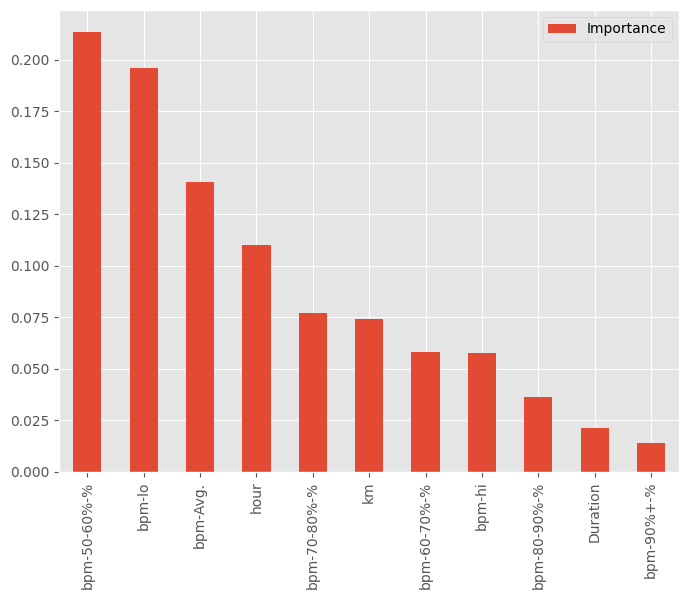

Runtime: 10.91s


In [132]:
from sklearn.ensemble import GradientBoostingRegressor
start = time.perf_counter()

param_grid_gbrt = {'n_estimators': range(300,400,10),'learning_rate': [0.1,0.05,0.01,0.001],'max_depth': [1,2], 'subsample': [0.5,0.75,1]}

gbrt = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42069), cv=5, param_grid=param_grid_gbrt,n_jobs=-1)
gbrt.fit(X_train_processed, y_train)
gbrt_preds = gbrt.predict(X_test_processed)

print(gbrt.best_estimator_)

print(paramResults(gbrt))
print(ResultsOut(gbrt))
featImport(gbrt)
print(f'Runtime: {round(time.perf_counter()-start,2)}s')

### XG Boost

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.25, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42069, ...)
     learning_rate_param  max_depth_param  n_estimators_param  \
0                   0.01                1                  10   
1                   0.01                1                  10   
2                   0.01                1                  10   
3

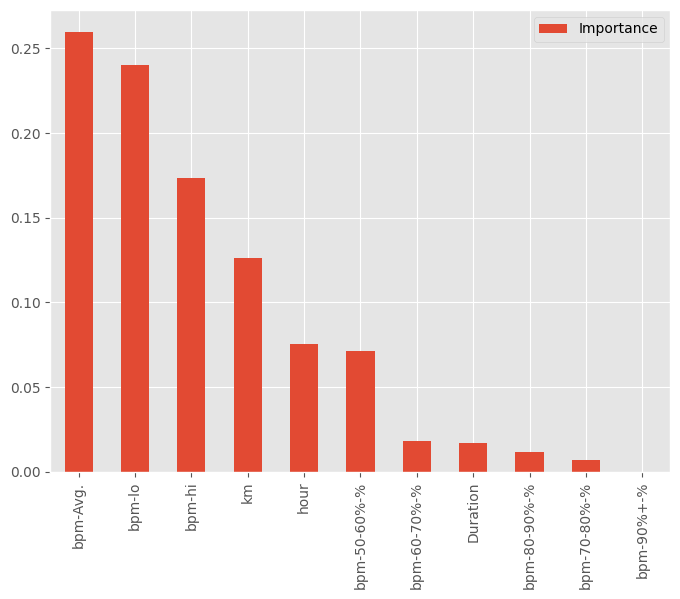

Runtime: 1.16s


In [133]:
from xgboost import XGBRegressor
start = time.perf_counter()

param_grid_xgb = {'n_estimators': [10,50,100,150,300],'learning_rate': [0.01,0.1, 0.25],'max_depth': [1,2,3,4], 'subsample':[0.5,0.75,1]}


xgb = GridSearchCV(estimator=XGBRegressor(random_state=42069), cv=5, param_grid=param_grid_xgb,n_jobs=-1)
xgb.fit(X_train_processed, y_train)
xgb_preds = xgb.predict(X_test_processed)

print(xgb.best_estimator_)
print(paramResults(xgb))
print(ResultsOut(xgb))
featImport(xgb)
print(f'Runtime: {round(time.perf_counter()-start,2)}s')

### XG Boost 2

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=700, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42069, ...)
    learning_rate_param  max_depth_param  n_estimators_param  subsample_param  \
0                  0.01                1                 300              0.6   
1                  0.01                1                 300              0.8   
2                 

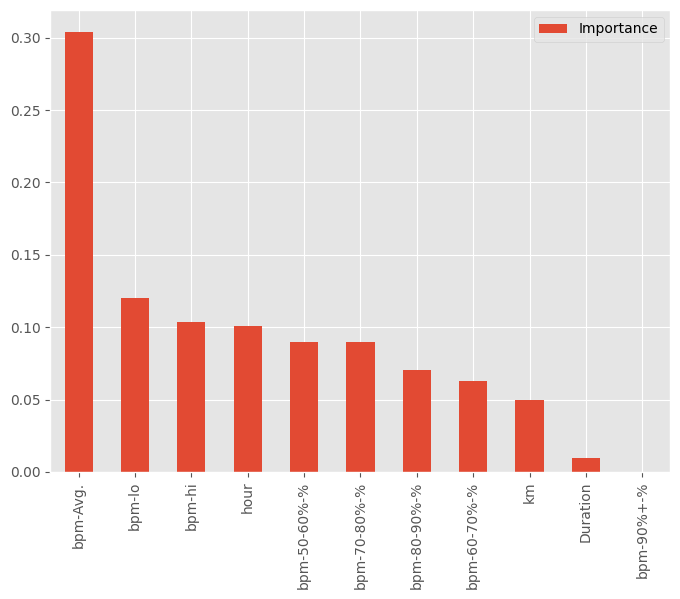

Runtime: 1.19s


In [134]:
start = time.perf_counter()
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [1,2],
    'subsample': [0.6, 0.8, 1.0],
    'n_estimators': [300, 500, 700]
}
xgbn = GridSearchCV(estimator=XGBRegressor(random_state=42069), cv=5, param_grid=param_grid_xgb,n_jobs=-1)
xgbn.fit(X_train_processed, y_train)
xgbn_preds = xgb.predict(X_test_processed)

print(xgbn.best_estimator_)
print(paramResults(xgbn))
print(ResultsOut(xgbn))
featImport(xgbn)
print(f'Runtime: {round(time.perf_counter()-start,2)}s')

In [135]:
modelss = [linreg,ridge,lasso,elasnet,pcr, knn,rf,gbrt,xgb,xgbn]
model_namess = ['Linear Regression', 'Ridge', 'Lasso', 'ElasticNet', 'Principal Component Regression',
              'K-Nearest Neighbors', 'Random Forest', 'Gradient Boosted Trees', 'XGBoost', 'XGBoost2']
def saveResults(models, model_names):
    # Initialize an empty dataframe to store the metrics
    metrics_df = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'R-squared', 'OOS R2'])
    
    # Loop through each model and calculate the metrics
    for i, model in enumerate(models):
        # Generate predictions on the test set
        y_pred = model.predict(X_test_processed)
        
        # Calculate regression metrics
        mae = round(mean_absolute_error(y_test, y_pred),3)
        mse = round(mean_squared_error(y_test, y_pred),3)
        rmse = round(mean_squared_error(y_test, y_pred, squared=False),3)
        r2 = round(r2_score(y_test, y_pred),3)
        oosr2 = round(1-mean_squared_error(y_test,y_pred)/MSE_Histmean,3)
        
        # Add metrics to the dataframe
        metrics_df.loc[i] = [model_names[i], mae, mse, rmse, r2, oosr2]
    
    metrics_df = metrics_df.sort_values('OOS R2', ascending=False).reset_index(drop=True)
    
    return metrics_df

saveResults(modelss,model_namess)

,Model,MAE,MSE,RMSE,R-squared,OOS R2
0,XGBoost2,0.301,0.136,0.369,-0.440,0.686
1,XGBoost,0.322,0.158,0.397,-0.672,0.636
2,Gradient Boosted Trees,0.351,0.167,0.408,-0.765,0.616
3,K-Nearest Neighbors,0.433,0.236,0.485,-1.495,0.457
4,Random Forest,0.487,0.274,0.523,-1.903,0.368
5,Lasso,0.626,0.546,0.739,-4.785,-0.260
6,Linear Regression,0.693,0.680,0.825,-6.207,-0.570
7,ElasticNet,0.694,0.691,0.831,-6.321,-0.594
8,Ridge,0.704,0.705,0.840,-6.471,-0.627
9,Principal Component Regression,1.081,2.508,1.584,-25.570,-4.787


In [136]:
print(f'Final Runtime: {round(time.perf_counter()-int_start,2)}s')

Final Runtime: 15.26s
